In [30]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation


In [31]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


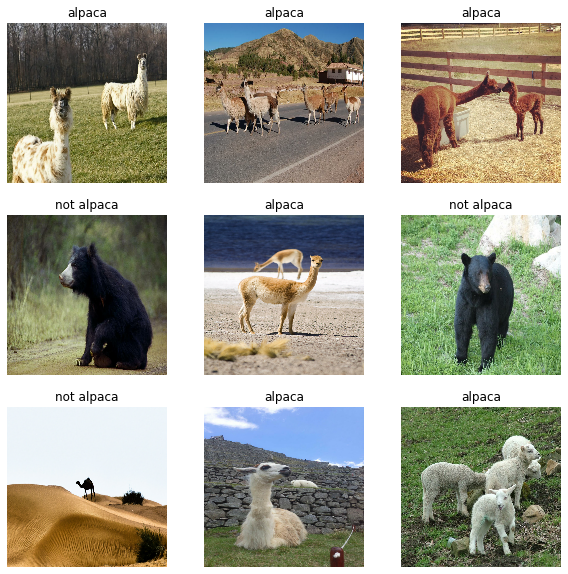

In [32]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [33]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [34]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

In [35]:
augmenter = data_augmenter()

assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
print('\033[92mAll tests passed!')


All tests passed!


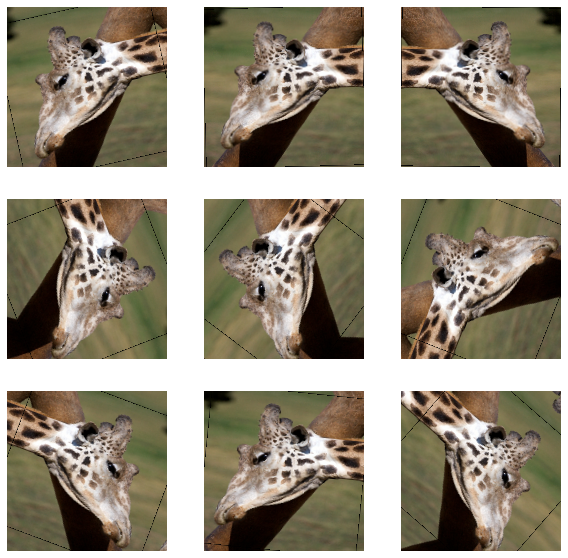

In [36]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [37]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [38]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [39]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d_2
predictions


In [40]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [41]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n04589890', 'window_screen', 0.42582113),
  ('n02708093', 'analog_clock', 0.09275588)],
 [('n04589890', 'window_screen', 0.23985851),
  ('n03887697', 'paper_towel', 0.14802593)],
 [('n04589890', 'window_screen', 0.7449468),
  ('n03598930', 'jigsaw_puzzle', 0.021948555)],
 [('n04589890', 'window_screen', 0.3354602),
  ('n03530642', 'honeycomb', 0.0762895)],
 [('n04589890', 'window_screen', 0.27327338),
  ('n03733281', 'maze', 0.08846959)],
 [('n04589890', 'window_screen', 0.6745217),
  ('n03530642', 'honeycomb', 0.076599255)],
 [('n04589890', 'window_screen', 0.79128474),
  ('n04209239', 'shower_curtain', 0.0924166)],
 [('n04589890', 'window_screen', 0.1646301),
  ('n03598930', 'jigsaw_puzzle', 0.08749153)],
 [('n03598930', 'jigsaw_puzzle', 0.37021384),
  ('n04589890', 'window_screen', 0.099569514)],
 [('n04589890', 'window_screen', 0.6161648),
  ('n03887697', 'paper_towel', 0.054877095)],
 [('n03530642', 'honeycomb', 0.254489),
  ('n04589890', 'window_screen', 0.24874294)],
 [('n04

In [42]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, 
                                                   weights='imagenet')
    
    base_model.trainable =  False

    inputs = tf.keras.Input(shape = input_shape) 
    
    x = data_augmentation(inputs)
    
    x = preprocess_input(x) 
    
    x = base_model(x, training=False) 
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    
    x = tf.keras.layers.Dropout(0.2)(x)
    
    prediction_layer = tf.keras.layers.Dense(1)
    outputs = prediction_layer(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [43]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [44]:
from test_utils import summary, comparator

alpaca_summary = [['InputLayer', [(None, 160, 160, 3)], 0],
                    ['Sequential', (None, 160, 160, 3), 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['Functional', (None, 5, 5, 1280), 2257984],
                    ['GlobalAveragePooling2D', (None, 1280), 0],
                    ['Dropout', (None, 1280), 0, 0.2],
                    ['Dense', (None, 1), 1281, 'linear']] #linear is the default activation

comparator(summary(model2), alpaca_summary)

for layer in summary(model2):
    print(layer)
    

All tests passed!
['InputLayer', [(None, 160, 160, 3)], 0]
['Sequential', (None, 160, 160, 3), 0]
['TensorFlowOpLayer', [(None, 160, 160, 3)], 0]
['TensorFlowOpLayer', [(None, 160, 160, 3)], 0]
['Functional', (None, 5, 5, 1280), 2257984]
['GlobalAveragePooling2D', (None, 1280), 0]
['Dropout', (None, 1280), 0, 0.2]
['Dense', (None, 1), 1281, 'linear']


The base learning rate has been set for you, so you can go ahead and compile the new model and run it for 5 epochs:

In [45]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 7s 824ms/step - loss: 0.7145 - accuracy: 0.6031 - val_loss: 0.5296 - val_accuracy: 0.6462
Epoch 2/5
9/9 [==============================] - 7s 778ms/step - loss: 0.5730 - accuracy: 0.6603 - val_loss: 0.4398 - val_accuracy: 0.7385
Epoch 3/5
9/9 [==============================] - 7s 791ms/step - loss: 0.4698 - accuracy: 0.7672 - val_loss: 0.3692 - val_accuracy: 0.8308
Epoch 4/5
9/9 [==============================] - 7s 791ms/step - loss: 0.4471 - accuracy: 0.7519 - val_loss: 0.3599 - val_accuracy: 0.8154
Epoch 5/5
9/9 [==============================] - 7s 779ms/step - loss: 0.4282 - accuracy: 0.7824 - val_loss: 0.3090 - val_accuracy: 0.8615


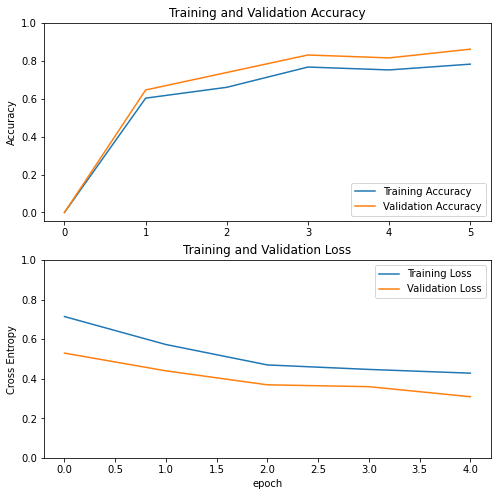

In [47]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [48]:
class_names

['alpaca', 'not alpaca']

In [49]:
base_model = model2.layers[4]
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits = True)

optimizer = tf.keras.optimizers.Adam(0.1 * base_learning_rate)

metrics= ['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  155


In [50]:
assert type(loss_function) == tf.python.keras.losses.BinaryCrossentropy, "Not the correct layer"
assert loss_function.from_logits, "Use from_logits=True"
assert type(optimizer) == tf.keras.optimizers.Adam, "This is not an Adam optimizer"
assert optimizer.lr == base_learning_rate / 10, "Wrong learning rate"
assert metrics[0] == 'accuracy', "Wrong metric"

print('\033[92mAll tests passed!')


All tests passed!


In [51]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 9s 1s/step - loss: 0.6519 - accuracy: 0.6908 - val_loss: 0.3209 - val_accuracy: 0.9077
Epoch 6/10
9/9 [==============================] - 9s 947ms/step - loss: 0.4266 - accuracy: 0.7519 - val_loss: 0.1975 - val_accuracy: 0.9692
Epoch 7/10
9/9 [==============================] - 9s 956ms/step - loss: 0.3206 - accuracy: 0.8817 - val_loss: 0.2138 - val_accuracy: 0.8462
Epoch 8/10
9/9 [==============================] - 9s 977ms/step - loss: 0.2676 - accuracy: 0.8664 - val_loss: 0.1280 - val_accuracy: 0.9846
Epoch 9/10
9/9 [==============================] - 9s 946ms/step - loss: 0.1958 - accuracy: 0.9160 - val_loss: 0.0732 - val_accuracy: 0.9846
Epoch 10/10
9/9 [==============================] - 9s 947ms/step - loss: 0.1834 - accuracy: 0.9427 - val_loss: 0.0607 - val_accuracy: 1.0000


In [52]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

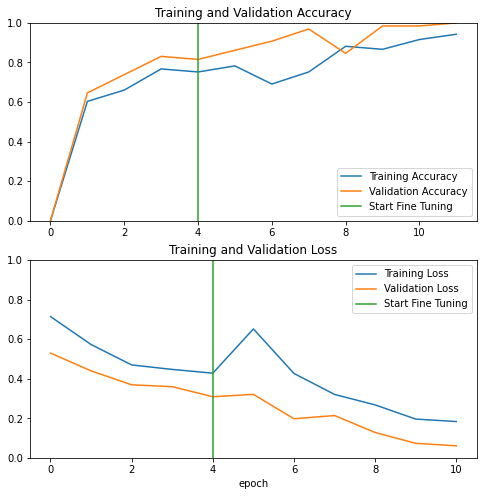

In [53]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()